Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing SSC limiting thresholds 15deg
Computing GRB PROMPT limiting thresholds
Plotting detection rates
0.10927310980929276 0.19064670222047103
0.15731329707623398 -0.039663607323981054
[[0.10927311]
 [0.1906467 ]]

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Uniform

Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing SSC limiting thresholds 15deg
Computing GRB PROMPT limiting thresholds
Plotting detection rates
2.408924386

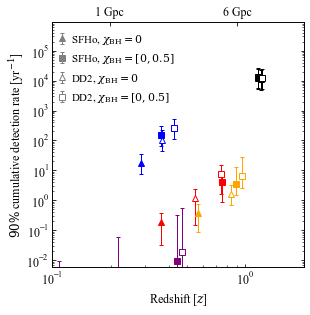

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions_ET import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 
import warnings
warnings.filterwarnings("ignore")

def error_variation(y,error_y,y_var,error_y_var):
    # Calcolo dei valori massimi e minimi
    y_min = y - error_y[0]  # Minimo di yssc
    y_max = y + error_y[1]  # Massimo di yssc
    
    y_var_min = y_var - error_y_var[0]  # Minimo di yssc_highdens
    y_var_max = y_var + error_y_var[1]  # Massimo di yssc_highdens
    
    # Determinazione degli estremi globali per le barre di errore
    global_min = np.minimum(y_min, y_var_min)  # Valore minimo globale
    global_max = np.maximum(y_max, y_var_max)  # Valore massimo globale
    
    # Calcolo delle nuove barre di errore per yssc
    new_error_low = y - global_min
    new_error_high = global_max - y
    errorSSC_new = np.array([new_error_low,new_error_high])
    
    return errorSSC_new
    
def error_variation_4(y1, error_y1, y2, error_y2, y3, error_y3, y4, error_y4):
    """
    Crea una banda di errore globale per il primo punto basata sui valori massimo e minimo
    di 4 punti con le loro barre di errore.

    Parametri:
        y1, y2, y3, y4: Valori centrali dei punti.
        error_y1, error_y2, error_y3, error_y4: Tuple (low, high) con gli errori inferiori e superiori per ciascun punto.

    Ritorna:
        new_error_y1: Tuple (low, high) con le nuove barre di errore per il primo punto.
    """
    # Calcolo dei valori massimo e minimo per ciascun punto considerando le barre di errore
    y1_min = y1 - error_y1[0]
    y1_max = y1 + error_y1[1]

    y2_min = y2 - error_y2[0]
    y2_max = y2 + error_y2[1]

    y3_min = y3 - error_y3[0]
    y3_max = y3 + error_y3[1]

    y4_min = y4 - error_y4[0]
    y4_max = y4 + error_y4[1]

    # Determinazione del minimo e massimo globale
    global_min = min(y1_min, y2_min, y3_min, y4_min)  # Valore minimo globale
    global_max = max(y1_max, y2_max, y3_max, y4_max)  # Valore massimo globale

    # Calcolo delle nuove barre di errore per il primo punto
    new_error_low = y1 - global_min
    new_error_high = global_max - y1

    return (new_error_low, new_error_high)


distribution = 'NOT fixed' #fixed or 'NOT fixed'
DCOtype='BHNS'
poptype='A'


if poptype == 'A':
    w_type='w_000'
    r0 = 81
    w_type_high = 'w_000'
    r0_high = 163
    w_type_low = 'w_000'
    r0_low = 34


#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=4.5,4.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False
plt.rcParams['legend.handlelength'] = 0

fig1,ax = plt.subplots(1,1)

num = 1000000
### --- Weights --- ###
spins = ['Zero','Uniform']

marker_style = ['^','s']
inside_style = [None,'w']

eos = ["SFHo","DD2"]

runs = ["ETT"]

for h in range(len(runs)):
    if h == 0:
        lim_snr = 12.
        
        lim_kn = np.array([26.,24.4,21.])
        
        lim_grb = np.asarray([1.e-2,1.5e-4,1.5e-6])
        
        lim_prompt_fermi = 3.09e-7
        fermi_duty = 0.6
        duty_CTA = 0.07
        
        
    if h == 1:
        lim_snr = 12.
        
        lim_kn = np.array([26.,24.4,21.])
        
        lim_grb = np.asarray([1.e-2,1.5e-4,1.5e-6])
        
        lim_prompt_fermi = 3.09e-7

    for k in range(len(eos)):
        if k == 0:
            mns_max = 2.058838
        if k == 1:
            mns_max = 2.422658
        table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos[k]),'r')
        
        path = '../horizons2/importance_sampling/mass_rate/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line!
        
        ### --- Loading Population --- ###
        
        print("Loading intrinsic population")
        mbh = table['mbh'][()]
        mns = table['mns'][()]
        lamb_ns = table['lamb_ns'][()]
        spin_bh = table['spin_bh'][()]
        z = table['z'][()]
        dL = table['dL'][()]
        thv = table['thv'][()]
        ra = table['ra'][()]
        dec = table['dec'][()]
        #pol = table['pol'][()]
        m_dyn = table['m_dyn'][()]
        v_dyn = table['v_dyn'][()]
        m_disk = table['m_disk'][()]
        m_out = table['m_out'][()]
        final_x = table['final_x'][()]
        E_bkt = table['E_bkt'][()]
        E_k_jet = table['E_k_jet'][()]
        Ec = table['Ec'][()]
        
        print("Loading GW population")
        snr_ETT = table['snr_ETT'][()]
        sky_loc_ETT = table['sky_loc_ETT'][()]
        snr_ETT = table['snr_ETT'][()]
        sky_loc_ETT = table['sky_loc_ETT'][()]
        snr_ETL = table['snr_ETL'][()]
        sky_loc_ETL = table['sky_loc_ETL'][()]        
        
        print("Loading EM population (kilonova)")
        kn_waves = table['kn_waves'][()]
        t_kn = table['t_kn'][()]
        lc_kn = table['lc_kn'][()]
        
        print("Loading EM population (GRB afterglow)")
        grb_nu = table['grb_nu'][()]
        t_grb = table['t_grb'][()]
        th = table['th'][()]
        lc_grb = table['lc_grb'][()]
        grb_nu_SSC = table['grb_nu_SSC'][()]
        t_grb_SSC = table['t_grb_SSC'][()]
        lc_grb_SSC_NoEBL = table['lc_grb_SSC'][()]
        lc_grb_SSC_NoEBL_highdens = table['lc_grb_SSC_highdens'][()]
        attenuation_EBL = table['attenuation_EBL'][()]
        lc_grb_SSC = lc_grb_SSC_NoEBL[:,:,:,0] * attenuation_EBL[:, :, np.newaxis]
        lc_grb_SSC_highdens = lc_grb_SSC_NoEBL_highdens[:,:,:,0] * attenuation_EBL[:, :, np.newaxis]
        lc_grb_SSC_15 = lc_grb_SSC_NoEBL[:,:,:,1] * attenuation_EBL[:, :, np.newaxis]
        lc_grb_SSC_highdens_15 = lc_grb_SSC_NoEBL_highdens[:,:,:,1] * attenuation_EBL[:, :, np.newaxis]
        
        print("Loading EM population (GRB prompt)")
        bol_fluence_prompt = table['bol_fluence_prompt'][()]
        
        table.close()
        
        np.random.seed(0)
        for i in range (len(spins)):
            spin_prescription = spins[i]
            spin = calculate_spin_olderCOMPASdata(data_path=path)
            if spin_prescription == 'Uniform':
                spinM1, spinM2  = spin.Bavera21()
                spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
                spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
            elif spin_prescription == 'Zero':
                spinM1, spinM2  = spin.Bavera21()
                spinM1 = np.random.uniform(0.,0.,spinM1.shape)
                spinM2 = np.random.uniform(0.,0.,spinM2.shape)
            
            bhx=[2.5,27]
            nsx=[1.1,3]
            spinx=[0.,1.]
            binsx=50
            binsy=50
            binsz=50
            
               
            if distribution == 'fixed':
                C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                
            
            if distribution == 'NOT fixed':
                #C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                #C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                #C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                table_w = h5py.File('./weights_BHNS/w_bhns_%s_%s_notfixed.hdf5' %(eos[k],spin_prescription),'r')
                C_mc = table_w['C_mc'][()]
                C_mc_low = table_w['C_mc_low'][()]
                C_mc_high = table_w['C_mc_high'][()]
                w = table_w['w'][()]
                w_low = table_w['w_low'][()]
                w_high = table_w['w_high'][()]
                table_w.close()
            
            print("")
            print("EoS:",eos[k])
            print("Population model:",poptype)
            print("The mass and spin distributions are", distribution)
            if distribution == 'fixed':
                print("The fiducial SFRD is", w_type, "with r0 =", r0)
                print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
                print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
            print("The spin prescription is:", spin_prescription)
            print("")
            
            #GW
            print("Computing GW limiting thresholds")
            np.random.seed(0)
    
            if h == 0:
                gw_det = snr_ETT >= lim_snr
            
            if h == 1:
                gw_det = snr_ETL >= lim_snr
            
    
            #KILONOVA
            print("Computing KN limiting thresholds")
            kn_peak = np.min(lc_kn, axis=2)
            kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
            for j in range(len(kn_waves)):
                kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
                kn_det[:,j] = kn_peak_APP <= lim_kn[j]
            kn_det_all = np.max(kn_det, axis = 1)
            kn_det_g = kn_det[:,0]
            kn_det_r = kn_det[:,1]
            kn_det_J = kn_det[:,2]
            
            #GRB AFTERGLOW
            print("Computing GRB AFTERGLOW limiting thresholds")
            grb_peak = np.max(lc_grb, axis=2)
            grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
            grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
            for j in range(len(grb_nu)):
                grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
                grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
            grb_det_all = np.max(grb_det, axis = 1)
            grb_det_radio = grb_det[:,0]
            grb_det_radio_15 = grb_det_15[:,0]
            grb_det_optic = grb_det[:,1]
            grb_det_x = grb_det[:,2]
            
            print("Computing SSC limiting thresholds")

            det_SSC = np.zeros([num, len(grb_nu_SSC)])
            det_SSC_highdens = np.zeros([num, len(grb_nu_SSC)])

            # Determine the hemisphere for each event based on the declination of the event
            emispheres = determine_emisphere(dec)

            # Calculate sensitivities for both bands and both hemispheres at once
            sensitivity_01 = sensitivity_CTA_vectorized(emispheres, "0.1", t_grb_SSC)
            sensitivity_1 = sensitivity_CTA_vectorized(emispheres, "1", t_grb_SSC)

            # Apply sensitivity thresholds to detect events
            mask_01 = lc_grb_SSC[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1 = lc_grb_SSC[:, 2, :] > sensitivity_1    # Broadcasting comparison
            mask_01_highdens = lc_grb_SSC_highdens[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1_highdens = lc_grb_SSC_highdens[:, 2, :] > sensitivity_1    # Broadcasting comparison

            # Use np.any along the time dimension to find detected events
            det_SSC[:, 1] = np.any(mask_01, axis=1)
            det_SSC[:, 2] = np.any(mask_1, axis=1)
            det_SSC_highdens[:, 1] = np.any(mask_01_highdens, axis=1)
            det_SSC_highdens[:, 2] = np.any(mask_1_highdens, axis=1)

            # Final detection mask
            grb_det_SSC_CTA = np.max(det_SSC, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
            grb_det_SSC_CTA_highdens = np.max(det_SSC_highdens, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
        
            print("Computing SSC limiting thresholds 15deg")
            
            det_SSC_15 = np.zeros([num, len(grb_nu_SSC)])
            det_SSC_highdens_15 = np.zeros([num, len(grb_nu_SSC)])
            
            # Determine the hemisphere for each event based on the declination of the event
            emispheres = determine_emisphere(dec)
            
            # Calculate sensitivities for both bands and both hemispheres at once
            sensitivity_01 = sensitivity_CTA_vectorized(emispheres, "0.1", t_grb_SSC)
            sensitivity_1 = sensitivity_CTA_vectorized(emispheres, "1", t_grb_SSC)
            
            # Apply sensitivity thresholds to detect events
            mask_01 = lc_grb_SSC_15[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1 = lc_grb_SSC_15[:, 2, :] > sensitivity_1    # Broadcasting comparison
            mask_01_highdens = lc_grb_SSC_highdens_15[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1_highdens = lc_grb_SSC_highdens_15[:, 2, :] > sensitivity_1    # Broadcasting comparison
            
            # Use np.any along the time dimension to find detected events
            det_SSC_15[:, 1] = np.any(mask_01, axis=1)
            det_SSC_15[:, 2] = np.any(mask_1, axis=1)
            det_SSC_highdens_15[:, 1] = np.any(mask_01_highdens, axis=1)
            det_SSC_highdens_15[:, 2] = np.any(mask_1_highdens, axis=1)
            
            # Final detection mask
            grb_det_SSC_CTA_15 = np.max(det_SSC_15, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
            grb_det_SSC_CTA_highdens_15 = np.max(det_SSC_highdens_15, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
                
            #GRB PROMPT
            print("Computing GRB PROMPT limiting thresholds")
            prompt_det_fermi = bol_fluence_prompt[:,0] >= lim_prompt_fermi ######CHANGE THIS LINE
            prompt_det_fermi_15 = bol_fluence_prompt[:,1] >= lim_prompt_fermi
            
            ### --- Computing detection Rates --- ###
            
            x = np.sort(z)
            s = np.argsort(z)
            
            #ALL NSNS
            cum_tot = C_mc*np.cumsum(w[s])
            cum_tot_high = C_mc_high*np.cumsum(w_high[s])
            cum_tot_low = C_mc_low*np.cumsum(w_low[s])
            
            #GW
            cum_gw = C_mc*np.cumsum(w[s]*gw_det[s])
            cum_gw_norm = cum_gw/cum_gw[-1]
            cum_gw_high = C_mc_high*np.cumsum(w_high[s]*gw_det[s])
            cum_gw_low = C_mc_low*np.cumsum(w_low[s]*gw_det[s])
            
            #KN
            cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]
            
            #GRB AFTERGLOW
            cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]
            cum_gw_grb_radio_15 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_15[s]*gw_det[s])
            cum_gw_grb_radio_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_15[s]*gw_det[s])
            cum_gw_grb_radio_15_norm = cum_gw_grb_radio_15/cum_gw_grb_radio_15[-1]
            
            cum_gw_SSC_CTA =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det[s])
            cum_gw_SSC_CTA_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det[s])
            cum_gw_SSC_CTA_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det[s])
            cum_gw_SSC_CTA_norm = cum_gw_SSC_CTA/cum_gw_SSC_CTA[-1]
            
            cum_gw_SSC_CTA_15 =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA_15[s]*gw_det[s])
            cum_gw_SSC_CTA_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA_15[s]*gw_det[s])
            cum_gw_SSC_CTA_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA_15[s]*gw_det[s])
            cum_gw_SSC_CTA_15_norm = cum_gw_SSC_CTA_15/cum_gw_SSC_CTA_15[-1]
            
            cum_gw_SSC_CTA_highdens =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_norm = cum_gw_SSC_CTA_highdens/cum_gw_SSC_CTA_highdens[-1]
            
            cum_gw_SSC_CTA_highdens_15 =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA_highdens_15[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA_highdens_15[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA_highdens_15[s]*gw_det[s])
            cum_gw_SSC_CTA_highdens_15_norm = cum_gw_SSC_CTA_highdens_15/cum_gw_SSC_CTA_highdens_15[-1]
                
            #GRB PROMPT 
            #cum_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]) 
            cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
            cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det[s])
            cum_gw_fermi_15_norm = cum_gw_fermi_15/cum_gw_fermi_15[-1]
            cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_15[s]*gw_det[s])
            cum_gw_fermi_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_15[s]*gw_det[s])
            
            ### --- Plotting detection Rates --- ###
            print("Plotting detection rates")
            skip = 30000
            skip2 = 1
            perc = 0.9
            xgw = np.interp(perc,cum_gw_norm[::skip],x[::skip])
            ygw = np.interp(xgw,x[::skip],cum_gw[::skip])
            xkn = np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip])
            ykn = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            
            xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
            yfermi = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*fermi_duty)
            xfermi_15 = np.interp(perc,cum_gw_fermi_15_norm[::skip],x[::skip])
            yfermi_15 = np.interp(xfermi,x[::skip],cum_gw_fermi_15[::skip]*fermi_duty)
            
            xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
            ygrb = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            xgrb_15 = np.interp(perc,cum_gw_grb_radio_15_norm[::skip],x[::skip])
            ygrb_15 = np.interp(xgrb_15,x[::skip],cum_gw_grb_radio_15[::skip])
            
            xssc = np.interp(perc,cum_gw_SSC_CTA_norm[::skip],x[::skip])
            yssc= np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA)
            xssc_highdens = np.interp(perc,cum_gw_SSC_CTA_highdens_norm[::skip],x[::skip])
            yssc_highdens= np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA)
            
            xssc_15 = np.interp(perc,cum_gw_SSC_CTA_15_norm[::skip],x[::skip])
            yssc_15= np.interp(xssc_15,x[::skip],cum_gw_SSC_CTA_15[::skip]*duty_CTA)
            xssc_highdens_15 = np.interp(perc,cum_gw_SSC_CTA_highdens_15_norm[::skip],x[::skip])
            yssc_highdens_15= np.interp(xssc_highdens_15,x[::skip],cum_gw_SSC_CTA_highdens_15[::skip]*duty_CTA)
         
            errorGW_low = np.interp(xgw,x[::skip],cum_gw[::skip]) - np.interp(xgw,x[::skip],cum_gw_low[::skip])
            errorGW_high = np.interp(xgw,x[::skip],cum_gw_high[::skip]) - np.interp(xgw,x[::skip],cum_gw[::skip])
            errorGW = np.array([[errorGW_low,errorGW_high]]).T
            
            errorKN_low = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g_low[::skip])
            errorKN_high = np.interp(xkn,x[::skip],cum_gw_kn_g_high[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            errorKN = np.array([[errorKN_low,errorKN_high]]).T
            
            errorGRB_low = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_low[::skip])
            errorGRB_high = np.interp(xgrb,x[::skip],cum_gw_grb_radio_high[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            errorGRB = np.array([[errorGRB_low,errorGRB_high]]).T            
            print(errorGRB_low,errorGRB_high)
            
            errorGRB_low_15 = np.interp(xgrb_15,x[::skip],cum_gw_grb_radio_15[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_low_15[::skip])
            errorGRB_high_15 = np.interp(xgrb_15,x[::skip],cum_gw_grb_radio_high_15[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_15[::skip])
            errorGRB_15 = np.array([[errorGRB_low_15,errorGRB_high_15]]).T
            
            errorGRB_new = error_variation(ygrb,errorGRB, ygrb_15,errorGRB_15)
    
            print(errorGRB_low_15,errorGRB_high_15)
            print(errorGRB)

            errorSSC_low = np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA) - np.interp(xssc,x[::skip],cum_gw_SSC_CTA_low[::skip]*duty_CTA)
            errorSSC_high = np.interp(xssc,x[::skip],cum_gw_SSC_CTA_high[::skip]*duty_CTA) - np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA)
            errorSSC = np.array([[errorSSC_low,errorSSC_high]]).T
            
            errorSSC_low_15 = np.interp(xssc_15,x[::skip],cum_gw_SSC_CTA_15[::skip]*duty_CTA) - np.interp(xssc_15,x[::skip],cum_gw_SSC_CTA_low_15[::skip]*duty_CTA)
            errorSSC_high_15 = np.interp(xssc_15,x[::skip],cum_gw_SSC_CTA_high_15[::skip]*duty_CTA) - np.interp(xssc_15,x[::skip],cum_gw_SSC_CTA_15[::skip]*duty_CTA)
            errorSSC_15 = np.array([[errorSSC_low_15,errorSSC_high_15]]).T
        
            errorSSC_highdens_low = np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA) - np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens_low[::skip]*duty_CTA)
            errorSSC_highdens_high = np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens_high[::skip]*duty_CTA) - np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA)
            errorSSC_highdens = np.array([[errorSSC_highdens_low,errorSSC_highdens_high]]).T
            
            errorSSC_highdens_low_15 = np.interp(xssc_highdens_15,x[::skip],cum_gw_SSC_CTA_highdens_15[::skip]*duty_CTA) - np.interp(xssc_highdens_15,x[::skip],cum_gw_SSC_CTA_highdens_low_15[::skip]*duty_CTA)
            errorSSC_highdens_high_15 = np.interp(xssc_highdens_15,x[::skip],cum_gw_SSC_CTA_highdens_high_15[::skip]*duty_CTA) - np.interp(xssc_highdens_15,x[::skip],cum_gw_SSC_CTA_highdens_15[::skip]*duty_CTA)
            errorSSC_highdens_15 = np.array([[errorSSC_highdens_low_15,errorSSC_highdens_high_15]]).T
            
            errorSSC_new = error_variation_4(yssc,errorSSC,yssc_15,errorSSC_15,yssc_highdens,errorSSC_highdens,yssc_highdens_15,errorSSC_highdens_15)
        
            errorFERMI_low = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*fermi_duty) - np.interp(xfermi,x[::skip],cum_gw_fermi_low[::skip]*fermi_duty)
            errorFERMI_high = np.interp(xfermi,x[::skip],cum_gw_fermi_high[::skip]*fermi_duty) - np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*fermi_duty)
            errorFERMI = np.array([[errorFERMI_low,errorFERMI_high]]).T
                        
            errorFERMI_low_15 = np.interp(xfermi,x[::skip],cum_gw_fermi_15[::skip]*fermi_duty) - np.interp(xfermi,x[::skip],cum_gw_fermi_low_15[::skip]*fermi_duty)
            errorFERMI_high_15 = np.interp(xfermi,x[::skip],cum_gw_fermi_high_15[::skip]*fermi_duty) - np.interp(xfermi,x[::skip],cum_gw_fermi_15[::skip]*fermi_duty)
            errorFERMI_15 = np.array([[errorFERMI_low_15,errorFERMI_high_15]]).T
            
            errorFERMI_new = error_variation(yfermi,errorFERMI, yfermi_15,errorFERMI_15)
  
            ax.errorbar(xgw,ygw,c='black',marker=marker_style[i],yerr=errorGW,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xkn,ykn,c='blue',marker=marker_style[i],yerr=errorKN,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xfermi,yfermi,ls="-",c='orange',marker=marker_style[i],yerr=errorFERMI_new,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xgrb,ygrb,ls="-",c='red',marker=marker_style[i],yerr=errorGRB_new,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xssc,yssc,ls="-",c='purple',marker=marker_style[i],yerr=errorSSC_new,elinewidth=1,capsize=2,mfc=inside_style[k])
                      
    
    ax.errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="SFHo, $\chi_\mathrm{BH} = 0$")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="s",yerr=1.,elinewidth=1,capsize=2,label="SFHo, $\chi_\mathrm{BH} = [0,0.5]$")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, $\chi_\mathrm{BH} = 0$")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="s",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, $\chi_\mathrm{BH} = [0,0.5]$")
    ax.legend(loc=2,frameon=False,prop={'size': 11})
    
    ylim = (0.006,9.e5)
    xlim = (0.1,2.)
    ax.set_xlabel('Redshift [$z$]',size=12)
    if h == 0:
        ax.set_ylabel(r'$90\%$ cumulative detection rate [yr$^{-1}$]',size=12)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.minorticks_on()
    ax2 = ax.twiny()
    ax2.set_xlim(xlim)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.minorticks_off()
    ax2.set_xticks([0.198,0.9045])
    ax2.set_xticklabels(('1 Gpc','6 Gpc'),size=12)
    #ax2.set_xlabel('Luminosity distance $d_\mathrm{L}$',size=11)
    if h == 1:
        ax.tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
        ax.tick_params(axis = 'x',direction='in',which='both',labelsize=12)
    if h == 0:
        ax.tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
    ax2.tick_params(direction='in',which='both',zorder=2)
    ax.yaxis.labelpad = 0.1
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.show()